In [9]:
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import seaborn as sb
sb.set()

In [10]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result


def get_metrics_internal(result, line):
    metrics = line.split(",")
    for metric in metrics:
        name, value = metric.split(":")
        result[name.strip()] = float(value.strip())
    return result 

def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    experiment_finished = True
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
                experiment_finished = False
                epoch = 0
            if 'val_ndcg_at_40' in line:
                    epoch += 1
                    epoch_metrics = get_metrics(line)
                    epoch_metrics['epoch'] = epoch
            if 'best_ndcg' in line:
                epoch_metrics = get_metrics_internal(epoch_metrics, line)
                metrics.append(epoch_metrics)

            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
                experiment_finished = True
            except:
                pass
    if not experiment_finished:
        experiment_results = {}
        experiment_results['model_name'] =  current_recommender
        experiment_results['metrics_history'] = metrics
        result.append(experiment_results)
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [12]:
experiment_logs = './results/bert4rec_config_2021_11_04T17_15_31/stdout'
data = get_data_from_logs(experiment_logs, 0)

In [13]:
df = pd.DataFrame(data).set_index('model_name').sort_values('ndcg@40')


In [14]:
df

,precision@5,ndcg@40,recall@5,SPS@10,MRR,MAP@10,apr@10,pairwise_cos_sim@10,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,,,,,
constant_recommender,0.00155,0.009452,0.00775,0.01475,0.005774,0.005147,45.700000,0.267025,0.000001,0.861365,{},[]
top_recommender,0.00595,0.041712,0.02975,0.05175,0.023715,0.017442,12.692800,0.266241,0.042226,5.616862,{'proxy_model': 'filter_seen_recommender'},[]
Salrec-BCE,0.00600,0.043174,0.03000,0.04875,0.024974,0.018205,18.115725,0.258610,6962.707846,130.095839,"{'epochs_trained': 49, 'best_val_ndcg': 0.0300...","[{'loss': 0.025, 'ndcg_at_40': 0.1546, 'val_lo..."
Salrec-BPR,0.00530,0.048477,0.02650,0.04975,0.026225,0.016923,392.418250,0.143447,19698.788460,140.381722,"{'epochs_trained': 70, 'best_val_ndcg': 0.0441...","[{'loss': 12863.7871, 'ndcg_at_40': 0.1405, 'v..."
lightfm_recommender_30_warp,0.00915,0.068957,0.04575,0.08225,0.038802,0.029343,968.668200,0.082849,552.217713,41.827747,{'proxy_model': 'filter_seen_recommender'},[]
svd_recommender_30,0.00905,0.070167,0.04525,0.08200,0.038664,0.028610,65.885275,0.205145,22.467686,49.345365,{'proxy_model': 'filter_seen_recommender'},[]
APREC-GMLPHE-BPR,0.01290,0.092056,0.06450,0.10350,0.052000,0.039373,145.012775,0.176811,19944.790260,124.703356,"{'epochs_trained': 117, 'best_val_ndcg': 0.073...","[{'loss': 22830.9023, 'ndcg_at_40': 0.1004, 'v..."
vanilla_bert4rec-400000,0.01565,0.098742,0.07825,0.12225,0.059081,0.047909,479.672075,0.115592,5761.073849,18.844913,{'proxy_model': 'filter_seen_recommender'},[]
APREC-GMLPHE-BCE,0.01560,0.101513,0.07800,0.13000,0.060746,0.049540,381.304500,0.116140,9890.285942,125.106212,"{'epochs_trained': 364, 'best_val_ndcg': 0.087...","[{'loss': 0.0118, 'ndcg_at_40': 0.0852, 'val_l..."


<Figure size 1152x648 with 0 Axes>

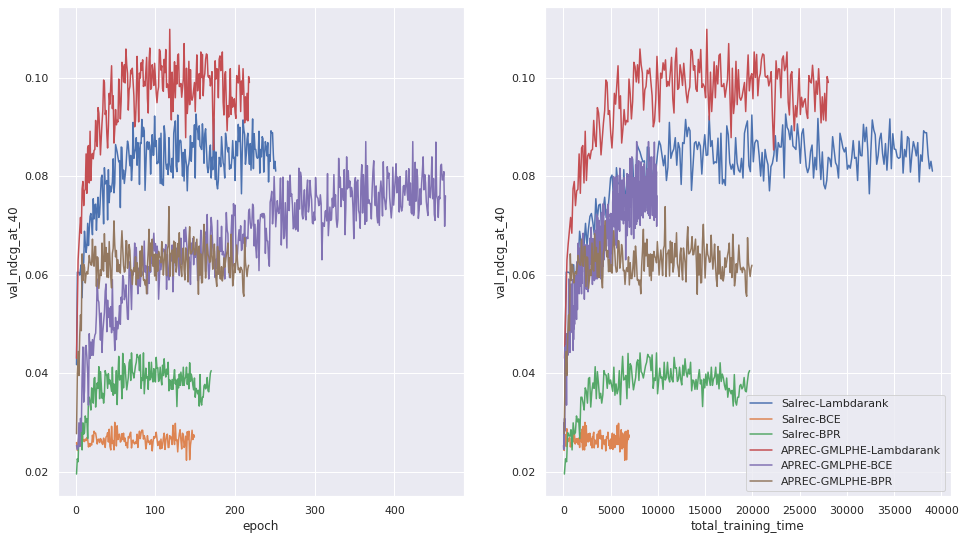

In [15]:
def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))

axises = ['epoch', 'total_training_time']
fig, ax = plt.subplots(1, len(axises))
fig.set_figheight(9)
fig.set_figwidth(16)

for recommender in data:
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        metric_name = 'val_ndcg_at_40'
        moving_average_steps=1
        metric = moving_average(get_metric(history, metric_name), moving_average_steps)
        
        #success = get_metric(history, 'Success_at_4')
        #val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        for axis_num in range(len(axises)):
            axis_name = axises[axis_num]
            axis = get_metric(history, axis_name)[moving_average_steps - 1:]
            ax[axis_num].plot(axis, metric,label=recommender['model_name'])
            ax[axis_num].set_xlabel(axis_name)
            ax[axis_num].set_ylabel(metric_name)

            
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


In [8]:
len(metric), len(metric) - np.argmax(metric) - 1

(217, 100)